# Transfer Learning

## Feature Extraction

In [3]:
# Inspect data files (10% of the total data from Food101)

import os

# Walk through data

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent\test
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent\test\fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent\test\grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent\test\hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent\test\pizza
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ramen
There are 0 directories and 250 images in 10_food_classes_10_percent\test\steak
There are 0 directories and 250 images in 10_food_classes_10_percent\test\sushi
There are 10 directori

In [4]:
# Creating data loaders
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode="categorical"
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [23]:
# Setting up TensorBoard callback
import datetime
from keras.callbacks import TensorBoard

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = f"{dir_name}/{experiment_name}"
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log file to {log_dir}")
    return tensorboard_callback

In [6]:
# Want to compare two models from tensorflow hub

resnet_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"

efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

### Resnet Model

In [18]:
# Making create_model function with arg: url

import tensorflow as tf
import tensorflow_hub as hub
from keras.layers import Input, Dense
from keras import Model

def create_model(model_url, num_class=10):
    """
    Take a TensorFlow Hub URL and creates a keras model with it.

    Args:
        model_url (str): TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in output layers.
    """

    # Download pretrained model and save it as a Keras layer
    feature_extraction_layer = hub.KerasLayer(model_url,
        trainable=False,
        name="Feature_extraction_layer"
    )

    input = Input(shape=(224, 224, 3))
    features = feature_extraction_layer(input)
    output = Dense(num_class, activation="softmax")(features)

    model = Model(inputs=[input], outputs=[output])
    return model

In [19]:
# Create Resnet model

resnet_model = create_model(resnet_url)

resnet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Feature_extraction_layer (K  (None, 1536)             54336736  
 erasLayer)                                                      
                                                                 
 dense_3 (Dense)             (None, 10)                15370     
                                                                 
Total params: 54,352,106
Trainable params: 15,370
Non-trainable params: 54,336,736
_________________________________________________________________


In [20]:
# Compile Resnet model

from keras.losses import categorical_crossentropy
from keras.optimizers import Adam 

resnet_model.compile(loss=categorical_crossentropy,
    optimizer=Adam(),
    metrics=["accuracy"])

In [24]:
# Train Resnet model

resnet_history = resnet_model.fit(train_data, 
    epochs=5, 
    validation_data=test_data,
    callbacks=[create_tensorboard_callback("tensorflow_hub", experiment_name="resnet_model_food101")])

Saving TensorBoard log file to tensorflow_hub/resnet_model_food101
Epoch 1/5
24/24 [==============================] - 52s 2s/step - loss: 1.5267 - accuracy: 0.4880 - val_loss: 0.9578 - val_accuracy: 0.6708
Epoch 2/5
24/24 [==============================] - 33s 1s/step - loss: 0.8466 - accuracy: 0.7293 - val_loss: 0.7162 - val_accuracy: 0.7704
Epoch 3/5
24/24 [==============================] - 34s 1s/step - loss: 0.6845 - accuracy: 0.7800 - val_loss: 0.6728 - val_accuracy: 0.7824
Epoch 4/5
24/24 [==============================] - 34s 1s/step - loss: 0.6029 - accuracy: 0.8267 - val_loss: 0.7026 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 34s 1s/step - loss: 0.5432 - accuracy: 0.8400 - val_loss: 0.6591 - val_accuracy: 0.7804


<Axes: >

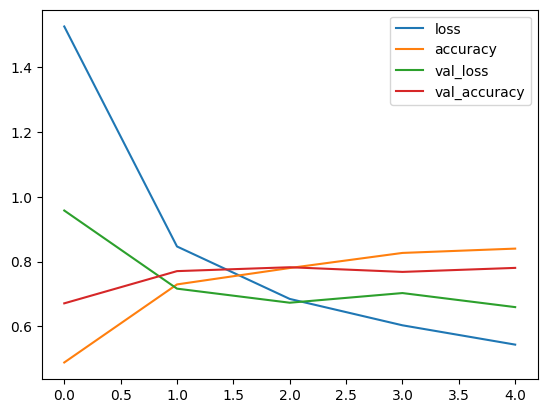

In [25]:
# Plot loss curve
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(resnet_history.history).plot()

### Efficientnet Model

In [26]:
# Create Efficientnet model

efficient_model = create_model(efficientnet_url)

efficient_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 dense_4 (Dense)             (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


In [27]:
# Compile Efficientnet model

from keras.losses import categorical_crossentropy
from keras.optimizers import Adam 

efficient_model.compile(loss=categorical_crossentropy,
    optimizer=Adam(),
    metrics=["accuracy"])

In [28]:
# Train Efficientnet model

efficient_history = efficient_model.fit(train_data, 
    epochs=5, 
    validation_data=test_data,
    callbacks=[create_tensorboard_callback("tensorflow_hub", experiment_name="efficientnet_model_food101")])

Saving TensorBoard log file to tensorflow_hub/efficientnet_model_food101
Epoch 1/5
24/24 [==============================] - 25s 652ms/step - loss: 1.9335 - accuracy: 0.3560 - val_loss: 1.5055 - val_accuracy: 0.6004
Epoch 2/5
24/24 [==============================] - 13s 569ms/step - loss: 1.2981 - accuracy: 0.6680 - val_loss: 1.1216 - val_accuracy: 0.7116
Epoch 3/5
24/24 [==============================] - 13s 552ms/step - loss: 1.0071 - accuracy: 0.7560 - val_loss: 0.9530 - val_accuracy: 0.7416
Epoch 4/5
24/24 [==============================] - 13s 550ms/step - loss: 0.8447 - accuracy: 0.7853 - val_loss: 0.8606 - val_accuracy: 0.7568
Epoch 5/5
24/24 [==============================] - 13s 575ms/step - loss: 0.7335 - accuracy: 0.8240 - val_loss: 0.7984 - val_accuracy: 0.7660


<Axes: >

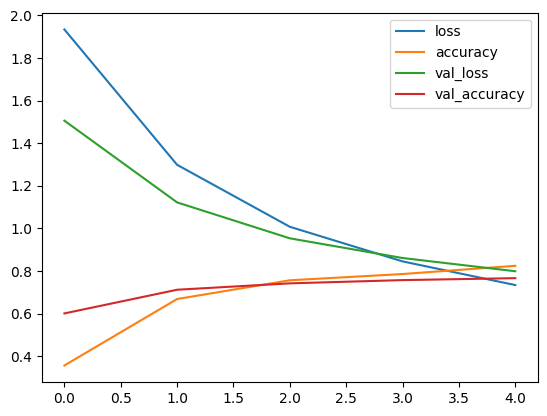

In [29]:
# Plot loss curve
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(efficient_history.history).plot()

### Comparing models using TensorBoard

In [32]:
# Launching in TensorBoard

import tensorboard

## Fine Tuning

### Now investigate the keras.applications pre-trained models

Feature Extraction With 10% Training Data

In [6]:
# Get data

# Creating data loaders
import tensorflow as tf
from keras.utils.image_dataset import image_dataset_from_directory

BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_data = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_data = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [22]:
# Setting up TensorBoard callback
import datetime
from keras.callbacks import TensorBoard

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = f"{dir_name}/{experiment_name}"
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log file to {log_dir}")
    return tensorboard_callback

In [27]:
# Create base model using tf.keras.applications

from keras.applications.efficientnet import EfficientNetB0
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras import Model

tf.random.set_seed(42)

# First create another feature extraction model
base_model = EfficientNetB0(include_top=False)

# Freeze base model
base_model.trainable = False

# Create model
input = Input(shape=(224, 224, 3))
# No rescaling layer required since it's built-in
x = base_model(input)
x = GlobalAveragePooling2D()(x)
output = Dense(10, activation="softmax")(x)

model = Model(inputs=[input], outputs=[output])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [28]:
# Compile model

from keras.losses import categorical_crossentropy
from keras.optimizers import Adam 

model.compile(loss=categorical_crossentropy,
    optimizer=Adam(),
    metrics=["accuracy"])

In [29]:
# Train model

history = model.fit(train_data, 
    epochs=5, 
    validation_data=test_data,
    callbacks=[create_tensorboard_callback("tensorflow_hub", experiment_name="efficientnet_model_food101_10%")])

Saving TensorBoard log file to tensorflow_hub/efficientnet_model_food101_10%
Epoch 1/5
24/24 [==============================] - 20s 563ms/step - loss: 1.8766 - accuracy: 0.4067 - val_loss: 1.2979 - val_accuracy: 0.7236
Epoch 2/5
24/24 [==============================] - 11s 454ms/step - loss: 1.0959 - accuracy: 0.7560 - val_loss: 0.8742 - val_accuracy: 0.8016
Epoch 3/5
24/24 [==============================] - 11s 447ms/step - loss: 0.7879 - accuracy: 0.8347 - val_loss: 0.7001 - val_accuracy: 0.8268
Epoch 4/5
24/24 [==============================] - 11s 446ms/step - loss: 0.6367 - accuracy: 0.8733 - val_loss: 0.6118 - val_accuracy: 0.8440
Epoch 5/5
24/24 [==============================] - 10s 432ms/step - loss: 0.5443 - accuracy: 0.8787 - val_loss: 0.5583 - val_accuracy: 0.8552


<Axes: >

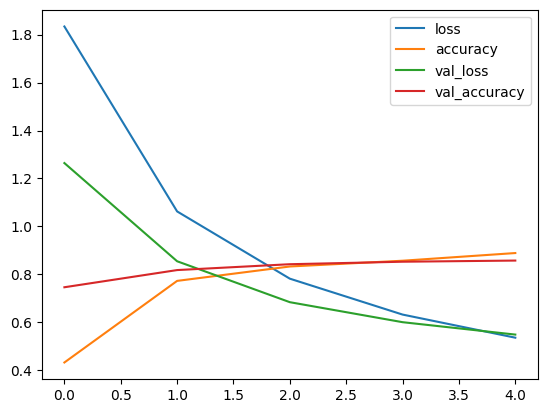

In [19]:
import pandas as pd

pd.DataFrame(history.history).plot()

Feature Extraction with 10% Augmented Training Data

In [43]:
# Create base model using tf.keras.applications

from keras.applications.efficientnet import EfficientNetB0
from keras.layers import(
    Input, 
    Dense, 
    GlobalAveragePooling2D, 
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomHeight,
    RandomWidth)

from keras import Model, Sequential

tf.random.set_seed(42)

# Create data augmentation layer
data_aug = Sequential([
    RandomFlip("horizontal"),
    RandomHeight(0.2),
    RandomRotation(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2)], name="data_aug_layer")

# First create another feature extraction model
base_model = EfficientNetB0(include_top=False)

# Freeze base model
base_model.trainable = False

# Create model
input = Input(shape=(224, 224, 3), name="input_layer")
# No rescaling layer required since it's built-in
x = data_aug(input)
x = base_model(x)
x = GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
output = Dense(10, activation="softmax", name="output_layer")(x)

model_2 = Model(inputs=[input], outputs=[output])

model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug_layer (Sequential)  (None, 224, 224, 3)      0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D_l  (None, 1280)             0         
 ayer (GlobalAveragePooling2                                     
 D)                                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [44]:
# Compile model

from keras.losses import categorical_crossentropy
from keras.optimizers import Adam 

model_2.compile(loss=categorical_crossentropy,
    optimizer=Adam(),
    metrics=["accuracy"])

In [45]:
# Train model

history_2 = model_2.fit(train_data, 
    epochs=5, 
    validation_data=test_data,
    callbacks=[create_tensorboard_callback("tensorflow_hub", experiment_name="efficientnet_model_food101_10%_aug")])

Saving TensorBoard log file to tensorflow_hub/efficientnet_model_food101_10%_aug
Epoch 1/5
24/24 [==============================] - 27s 727ms/step - loss: 1.9910 - accuracy: 0.3467 - val_loss: 1.4794 - val_accuracy: 0.6804
Epoch 2/5
24/24 [==============================] - 15s 628ms/step - loss: 1.3254 - accuracy: 0.6920 - val_loss: 1.0241 - val_accuracy: 0.7788
Epoch 3/5
24/24 [==============================] - 15s 640ms/step - loss: 1.0095 - accuracy: 0.7520 - val_loss: 0.8112 - val_accuracy: 0.8180
Epoch 4/5
24/24 [==============================] - 14s 606ms/step - loss: 0.8744 - accuracy: 0.7787 - val_loss: 0.7048 - val_accuracy: 0.8320
Epoch 5/5
24/24 [==============================] - 15s 618ms/step - loss: 0.7725 - accuracy: 0.8040 - val_loss: 0.6463 - val_accuracy: 0.8364


<Axes: >

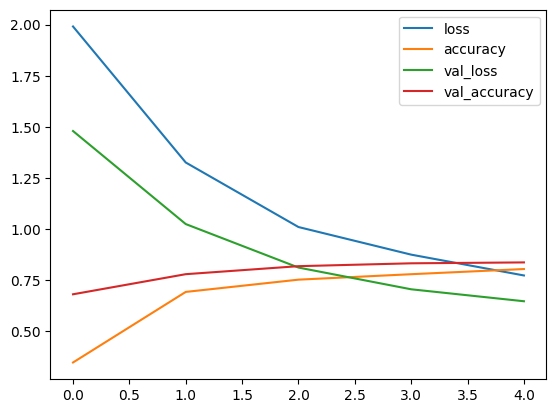

In [61]:
import pandas as pd

pd.DataFrame(history_2.history).plot()

Fine-Tuning Model with an extra 5 epochs

In [58]:
# Want to make the last 10 layers in the base model of 
# model 2 trainable

from keras.applications.efficientnet import EfficientNetB0
from keras.layers import(
    Input, 
    Dense, 
    GlobalAveragePooling2D, 
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomHeight,
    RandomWidth)

from keras import Model, Sequential

tf.random.set_seed(42)

# Create data augmentation layer
data_aug = Sequential([
    RandomFlip("horizontal"),
    RandomHeight(0.2),
    RandomRotation(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2)], name="data_aug_layer")

# First create another feature extraction model
base_model = EfficientNetB0(include_top=False)

# Freeze base model except for last ten layers
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

# Create model
input = Input(shape=(224, 224, 3), name="input_layer")
# No rescaling layer required since it's built-in
x = data_aug(input)
x = base_model(x)
x = GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
output = Dense(10, activation="softmax", name="output_layer")(x)

model_3 = Model(inputs=[input], outputs=[output])

model_3.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug_layer (Sequential)  (None, 224, 224, 3)      0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D_l  (None, 1280)             0         
 ayer (GlobalAveragePooling2                                     
 D)                                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-trai

In [59]:
# Compile Model

model_3.compile(loss=categorical_crossentropy,
    optimizer=Adam(learning_rate=1e-4), # Learning rate scaled down by factor of 10 for fine-tuning
    metrics=["accuracy"])

In [60]:
# Train Model

history_3 = model_3.fit(train_data, 
    epochs=10, 
    validation_data=test_data,
    callbacks=[create_tensorboard_callback("tensorflow_hub", experiment_name="efficientnet_model_food101_10%_aug_finetune")])

Saving TensorBoard log file to tensorflow_hub/efficientnet_model_food101_10%_aug_finetune
Epoch 1/10
24/24 [==============================] - 28s 726ms/step - loss: 2.1903 - accuracy: 0.2040 - val_loss: 1.8683 - val_accuracy: 0.4076
Epoch 2/10
24/24 [==============================] - 15s 622ms/step - loss: 1.7459 - accuracy: 0.5547 - val_loss: 1.4347 - val_accuracy: 0.6648
Epoch 3/10
24/24 [==============================] - 15s 622ms/step - loss: 1.3968 - accuracy: 0.6907 - val_loss: 1.1366 - val_accuracy: 0.7572
Epoch 4/10
24/24 [==============================] - 15s 625ms/step - loss: 1.1902 - accuracy: 0.7373 - val_loss: 0.9257 - val_accuracy: 0.7932
Epoch 5/10
24/24 [==============================] - 15s 630ms/step - loss: 1.0055 - accuracy: 0.7960 - val_loss: 0.7842 - val_accuracy: 0.8112
Epoch 6/10
24/24 [==============================] - 15s 614ms/step - loss: 0.9012 - accuracy: 0.7867 - val_loss: 0.6877 - val_accuracy: 0.8256
Epoch 7/10
24/24 [==============================] - 

<Axes: >

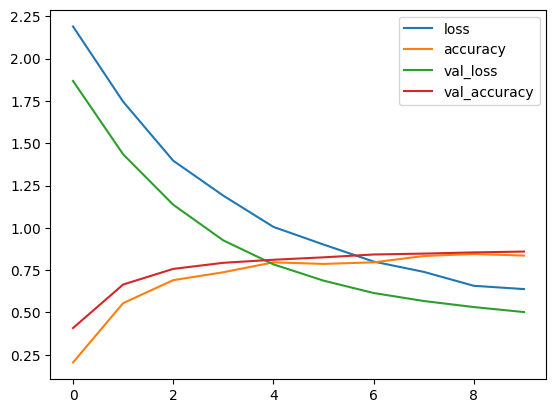

In [62]:
import pandas as pd

pd.DataFrame(history_3.history).plot()

In [63]:
# Compare inital model with fine-tuned model

model.evaluate(test_data)
model_3.evaluate(test_data)

79/79 [==============================] - 8s 101ms/step - loss: 0.5021 - accuracy: 0.8596


[0.5020517706871033, 0.8596000075340271]

Fine-tuning previous model now using 100% of the training data

In [66]:
# Get all data

# Creating data loaders
import tensorflow as tf
from keras.utils.image_dataset import image_dataset_from_directory

BATCH_SIZE = 32

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

train_data_all = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_data_all = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [67]:
# Want to make the last 10 layers in the base model of 
# model 2 trainable

from keras.applications.efficientnet import EfficientNetB0
from keras.layers import(
    Input, 
    Dense, 
    GlobalAveragePooling2D, 
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomHeight,
    RandomWidth)

from keras import Model, Sequential

tf.random.set_seed(42)

# Create data augmentation layer
data_aug = Sequential([
    RandomFlip("horizontal"),
    RandomHeight(0.2),
    RandomRotation(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2)], name="data_aug_layer")

# First create another feature extraction model
base_model = EfficientNetB0(include_top=False)

# Freeze base model except for last ten layers
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

# Create model
input = Input(shape=(224, 224, 3), name="input_layer")
# No rescaling layer required since it's built-in
x = data_aug(input)
x = base_model(x)
x = GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
output = Dense(10, activation="softmax", name="output_layer")(x)

model_4 = Model(inputs=[input], outputs=[output])

model_4.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug_layer (Sequential)  (None, 224, 224, 3)      0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D_l  (None, 1280)             0         
 ayer (GlobalAveragePooling2                                     
 D)                                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-trai

In [68]:
# Compile model

model_4.compile(loss=categorical_crossentropy,
    optimizer=Adam(learning_rate=1e-4), # Learning rate scaled down by factor of 10 for fine-tuning
    metrics=["accuracy"])

In [69]:
# Train Model

history_4 = model_4.fit(train_data_all, 
    epochs=10, 
    validation_data=test_data_all,
    callbacks=[create_tensorboard_callback("tensorflow_hub", experiment_name="efficientnet_model_food101_100%_aug_finetune")])

Saving TensorBoard log file to tensorflow_hub/efficientnet_model_food101_100%_aug_finetune
Epoch 1/10
235/235 [==============================] - 87s 325ms/step - loss: 1.2703 - accuracy: 0.6341 - val_loss: 0.4813 - val_accuracy: 0.8624
Epoch 2/10
235/235 [==============================] - 72s 305ms/step - loss: 0.7028 - accuracy: 0.7880 - val_loss: 0.3639 - val_accuracy: 0.8868
Epoch 3/10
235/235 [==============================] - 74s 314ms/step - loss: 0.5831 - accuracy: 0.8197 - val_loss: 0.3264 - val_accuracy: 0.8968
Epoch 4/10
235/235 [==============================] - 82s 350ms/step - loss: 0.5309 - accuracy: 0.8309 - val_loss: 0.3068 - val_accuracy: 0.8948
Epoch 5/10
235/235 [==============================] - 87s 371ms/step - loss: 0.4879 - accuracy: 0.8439 - val_loss: 0.2988 - val_accuracy: 0.9020
Epoch 6/10
235/235 [==============================] - 87s 370ms/step - loss: 0.4588 - accuracy: 0.8508 - val_loss: 0.2788 - val_accuracy: 0.9076
Epoch 7/10
235/235 [===================

<Axes: >

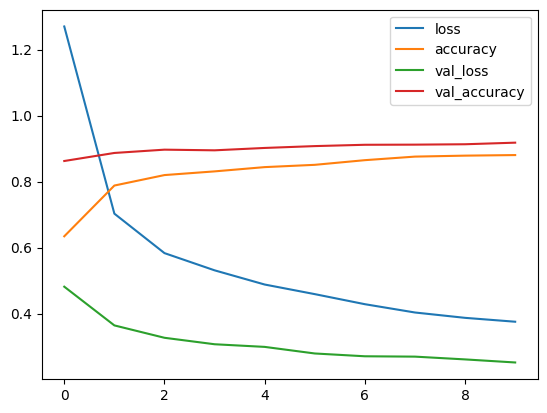

In [70]:
import pandas as pd

pd.DataFrame(history_4.history).plot()

In [71]:
# Compare original and final model

model.evaluate(test_data_all)

model_4.evaluate(test_data_all)

79/79 [==============================] - 8s 100ms/step - loss: 0.2515 - accuracy: 0.9180


[0.25152018666267395, 0.9179999828338623]

In [73]:
# Open TensorBoard

import tensorboard

## Scaling Up Transfer Learning to 101 Classes

In [1]:
# Inspect data files (10% of the total data from all 101 class Food101)

import os

# Walk through data

for dirpath, dirnames, filenames in os.walk("101_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 101_food_classes_10_percent
There are 101 directories and 0 images in 101_food_classes_10_percent\test
There are 0 directories and 250 images in 101_food_classes_10_percent\test\apple_pie
There are 0 directories and 250 images in 101_food_classes_10_percent\test\baby_back_ribs
There are 0 directories and 250 images in 101_food_classes_10_percent\test\baklava
There are 0 directories and 250 images in 101_food_classes_10_percent\test\beef_carpaccio
There are 0 directories and 250 images in 101_food_classes_10_percent\test\beef_tartare
There are 0 directories and 250 images in 101_food_classes_10_percent\test\beet_salad
There are 0 directories and 250 images in 101_food_classes_10_percent\test\beignets
There are 0 directories and 250 images in 101_food_classes_10_percent\test\bibimbap
There are 0 directories and 250 images in 101_food_classes_10_percent\test\bread_pudding
There are 0 directories and 250 images in 101_food_classes_10_percent\test\bre

In [13]:
# Get data

# Creating data loaders
import tensorflow as tf
from keras.utils.image_dataset import image_dataset_from_directory

BATCH_SIZE = 32

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

train_data = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_data = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [14]:
# Setting up TensorBoard and model checkpoint callback
from keras.callbacks import TensorBoard, ModelCheckpoint

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = f"{dir_name}/{experiment_name}"
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log file to {log_dir}")
    return tensorboard_callback

def create_modelcheckpoint_callback(dir_name, experiment_name):
    log_dir = f"{dir_name}/{experiment_name}"
    modelcheckpoint_callback = ModelCheckpoint(filepath=log_dir,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True)
    print(f"Saving model checkpoint to {log_dir}")
    return modelcheckpoint_callback

In [15]:
# Create model

from keras import Model, Sequential
from keras.applications import EfficientNetB0
from keras.layers import(
    Input, Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom)

tf.random.set_seed(42)

# Create data aug layer
data_aug = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomHeight(0.1),
    RandomWidth(0.1),
    RandomZoom(0.1)
], name="data_aug_layer")

# Create base model layer using EfficientNetB0
# Use only feature extraction
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

# Trainable top layers of model
input = Input(shape=(224, 224, 3), name="input_layer")
x = data_aug(input)
x = base_model(x)
x = GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
output = Dense(101, name="dense_layer", activation="softmax")(x)

model_5 = Model(inputs=[input], outputs=[output])

model_5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug_layer (Sequential)  (None, 224, 224, 3)      0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 dense_layer (Dense)         (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

In [16]:
# Compile Model

from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam

model_5.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=["accuracy"]
)

In [17]:
# Train Model

dir_name = "callbacks"
experiment_name = "101_food_classes_10_percent"

history_5 = model_5.fit(
    train_data, 
    epochs=5, 
    validation_data = test_data,
    callbacks=[
        create_tensorboard_callback(dir_name, experiment_name),
        create_modelcheckpoint_callback(dir_name, experiment_name)
    ]
)

Saving TensorBoard log file to callbacks/101_food_classes_10_percent
Saving model checkpoint to callbacks/101_food_classes_10_percent
Epoch 1/5
237/237 [==============================] - 160s 626ms/step - loss: 3.3443 - accuracy: 0.2772 - val_loss: 2.2487 - val_accuracy: 0.4905
Epoch 2/5
237/237 [==============================] - 148s 625ms/step - loss: 2.1108 - accuracy: 0.5212 - val_loss: 1.8121 - val_accuracy: 0.5568
Epoch 3/5
237/237 [==============================] - 159s 672ms/step - loss: 1.7248 - accuracy: 0.5946 - val_loss: 1.6572 - val_accuracy: 0.5765
Epoch 4/5
237/237 [==============================] - 165s 695ms/step - loss: 1.4975 - accuracy: 0.6393 - val_loss: 1.5776 - val_accuracy: 0.5884
Epoch 5/5
237/237 [==============================] - 169s 715ms/step - loss: 1.3443 - accuracy: 0.6721 - val_loss: 1.5332 - val_accuracy: 0.5954


<Axes: >

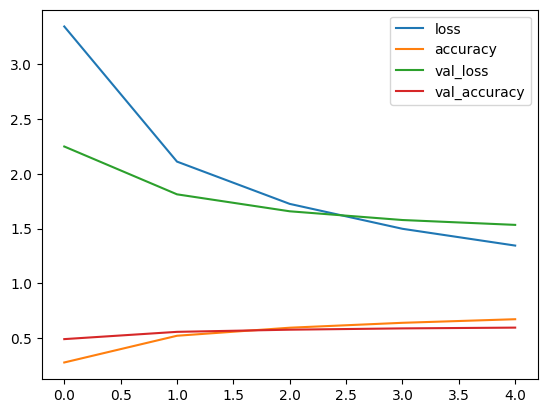

In [18]:
# Plot loss curves
import pandas as pd

pd.DataFrame(history_5.history).plot()

In [19]:
# Evaluate model

class_names = test_data.class_names

pred_probs = model_5.predict(test_data)
pred_classes = tf.argmax(pred_probs, axis=-1)

true_classes = []
for image, label in test_data.unbatch():
    true_classes.append(tf.argmax(label, axis=-1))

790/790 [==============================] - 84s 103ms/step


In [65]:
# Get classification report

from sklearn.metrics import classification_report

report = classification_report(
    y_true=true_classes,
    y_pred=pred_classes,
    output_dict=True
)

report

{'0': {'precision': 0.33076923076923076,
  'recall': 0.172,
  'f1-score': 0.2263157894736842,
  'support': 250},
 '1': {'precision': 0.4444444444444444,
  'recall': 0.752,
  'f1-score': 0.5586924219910847,
  'support': 250},
 '2': {'precision': 0.5609756097560976,
  'recall': 0.644,
  'f1-score': 0.5996275605214153,
  'support': 250},
 '3': {'precision': 0.8258064516129032,
  'recall': 0.512,
  'f1-score': 0.6320987654320988,
  'support': 250},
 '4': {'precision': 0.541871921182266,
  'recall': 0.44,
  'f1-score': 0.48565121412803536,
  'support': 250},
 '5': {'precision': 0.4972067039106145,
  'recall': 0.356,
  'f1-score': 0.41491841491841486,
  'support': 250},
 '6': {'precision': 0.735632183908046,
  'recall': 0.768,
  'f1-score': 0.75146771037182,
  'support': 250},
 '7': {'precision': 0.8154506437768241,
  'recall': 0.76,
  'f1-score': 0.7867494824016563,
  'support': 250},
 '8': {'precision': 0.2898550724637681,
  'recall': 0.56,
  'f1-score': 0.38199181446111874,
  'support': 2

<Axes: ylabel='class_names'>

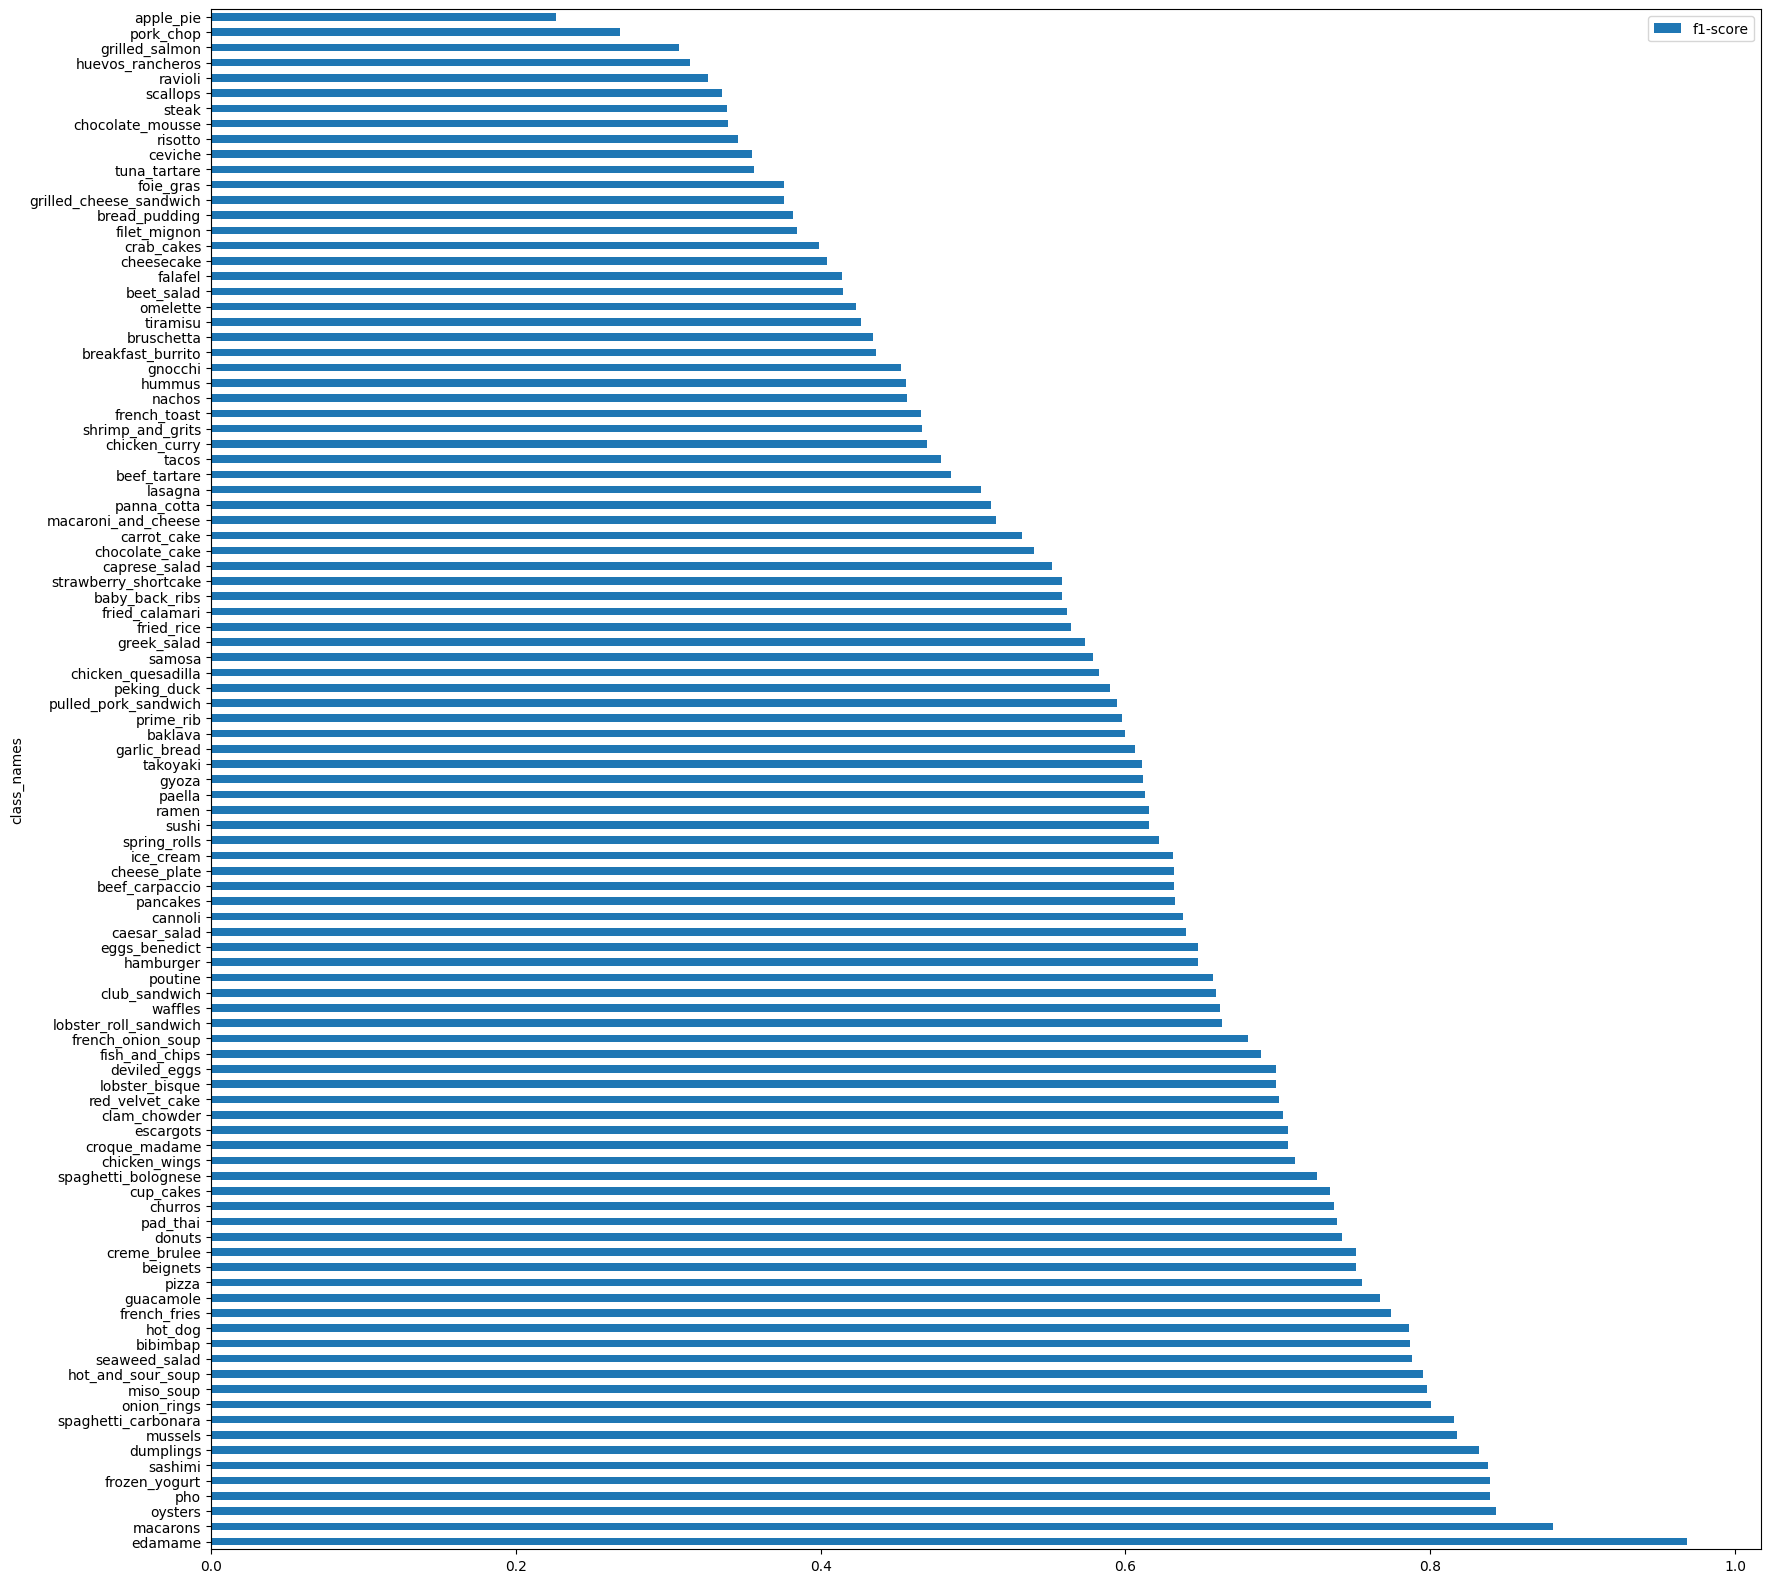

In [66]:
# Create bar chart of F1-scores

# Get list of all classes F1-scores
class_f1_scores = {}

for key, value in report.items():
    if key == "accuracy":
        break
    else:
        class_f1_scores[class_names[int(key)]] = value["f1-score"]

f1_scores = pd.DataFrame({
    "class_names": list(class_f1_scores.keys()),
    "f1-score": list(class_f1_scores.values())
}).sort_values("f1-score", ascending=False)

f1_scores.plot(x="class_names", y="f1-score", kind="barh", figsize=(20, 20))

In [72]:
# Create function to load and preprocess img

from keras.utils import load_img, img_to_array
import numpy as np


def load_process_img(img_filepath, resize, scale):
    # Read in image
    img = load_img(img_filepath, target_size=resize)
    img_tensor = tf.convert_to_tensor([img_to_array(img)])

    if scale == True:
        img_tensor = img_tensor / 255.
    
    return img_tensor

1/1 [==============================] - 0s 42ms/step


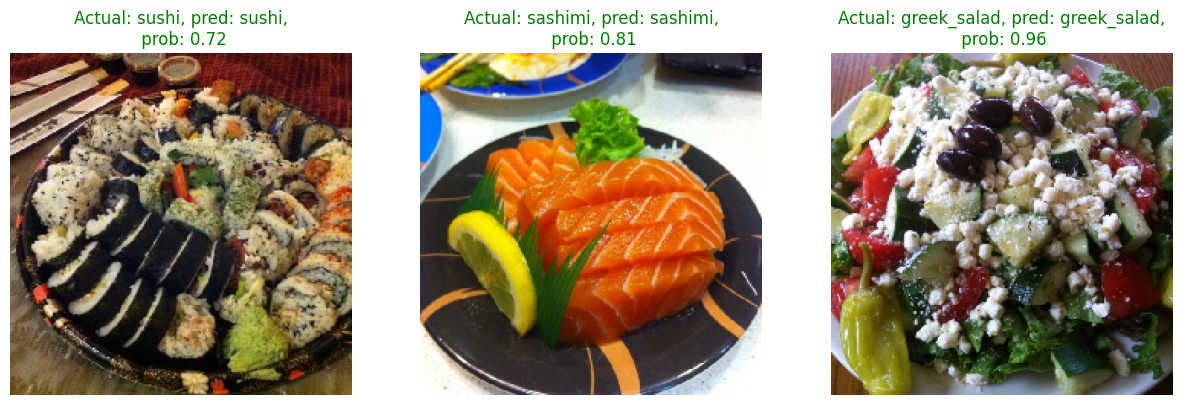

In [96]:
# Display random images and their predictions

import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(3):
    # Choose random img from a random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    # Load img and make prediction
    img = load_process_img(filepath, resize=(224, 224), scale=False)
    pred_probs = model_5.predict(img)
    pred_class = class_names[tf.argmax(pred_probs, axis=-1)[0].numpy()]

    plt.subplot(1, 3, i+1)
    plt.imshow(img[0, :, :, :] / 255.)
    if class_name == pred_class:
        title_col = "g"
    else:
        title_col = "r"

    plt.title(f"Actual: {class_name}, pred: {pred_class},\n prob: {pred_probs.max():.2f}", c=title_col)
    plt.axis(False)
